# Octane modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.svm import OneClassSVM

'''custom modules'''
from filter_data import Select_descriptors
from process_data import Scalar
from simmilarity import mean_tanimato,Leverage
from train import Model

In [2]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [3]:
df.head(5)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,boiling_point_K
0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,...,14,12,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13,0.9,390.81
1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,...,6,4,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2,-0.1,351.44
2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,...,2,1,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2,-0.5,337.85
3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,Training,100.25,...,10,8,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7,0.3,370.35
4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,NaN,NaN,...,30,31,2.361111,1.666667,NaN,118.17,no alternative,42,2.7,384.62


### 1. Data preprocessing

In [4]:
### 1.1 Remove columns with missing values
misssing_val_cols = df.columns[df.isnull().any()]
print('Columns with missing values are = {}'.format(list(misssing_val_cols)))

Columns with missing values are = ['Compound Name', 'TARGET', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON', 'dev', 'boiling_point_K']


In [5]:
### 1.2 Remove columns with irrelevant to modelling values
df_ = df.drop(misssing_val_cols,axis=1)

irrelevant_to_pred_columns = ['PubChem','ron_choice']

df_ = df_.drop(irrelevant_to_pred_columns,axis=1)

In [6]:
print('final dataset sie = {}'.format(df_.shape))

final dataset sie = (492, 879)


### 2. Split dataset (standartization must be applied on train set only )

In [11]:
seed = 42 # Fix random seed to make split reproducible (experiment must be reproducible)

X_train, X_test, y_train, y_test = train_test_split(df_.drop('y',axis=1), df_['y'], test_size=0.2, random_state=seed)

In [12]:
print('Train dataset size = {}'.format(X_train.shape))
print('Test dataset size = {}'.format(X_test.shape))

Train dataset size = (393, 878)
Test dataset size = (99, 878)


In [13]:
# Normilise features, so varince threshold can be applied
sc         = Scalar('minmax')

# Wrapper feature selector
wrapper    = sfs(SVR(gamma='auto'),
              n_features_to_select=50,
              scoring='neg_mean_squared_error',
              cv=5)

# Applies varience threshold, removes high correlated features, removes higly skewed vars and applies wrapper in the end.

Filter_    = Select_descriptors(0.01,0.95,None,wrapper)

sc.fit(X_train)

In [14]:
X_train  = Filter_.transform(sc.transform(X_train),y_train)

In [15]:
X_train.head(5)

,SMILES,nAromAtom,nAtom,AATS1dv,AATS1s,AATS2s,ATSC1dv,ATSC2Z,AATSC1dv,AATSC2v,...,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA8,nARing,nRot,RotRatio,JGT10,Radius,XLogP
0,Cc1c(C)cccc1C,1.0,0.517241,0.576389,0.282591,0.282991,0.730492,0.700621,0.740440,0.878198,...,0.000000,0.000000,0.324926,0.762583,0.000000,0.000000,0.000000,0.578490,0.50,0.640625
1,CC1CCCC(C1)C,0.0,0.620690,0.210069,0.047170,0.042662,0.230335,0.359969,0.366775,0.521145,...,0.000000,0.460837,0.500000,0.270972,0.333333,0.000000,0.000000,0.537208,0.50,0.671875
2,CC(c1ccccc1)(C)C,1.0,0.620690,0.513889,0.259434,0.279715,0.646858,0.675433,0.629969,0.813625,...,0.290739,0.000000,0.108309,1.000000,0.000000,0.000000,0.000000,0.646033,0.50,0.718750
3,CC(CC1CCCCC1)C,0.0,0.827586,0.202778,0.040431,0.042318,0.230335,0.271418,0.349309,0.476476,...,0.000000,0.460837,0.750000,0.270972,0.333333,0.285714,0.257143,0.457626,0.50,0.828125
4,CC1CCC(O1)C,0.0,0.448276,0.424342,0.155341,0.268083,0.511587,0.511983,0.614242,0.524690,...,0.655463,0.000000,0.250000,0.270972,0.333333,0.000000,0.000000,0.583679,0.25,0.265625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,CC(C)C(=O)C,0.0,0.344828,0.426389,0.350704,0.389112,0.529771,0.607913,0.721905,0.674332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.257143,0.637146,0.25,0.203125
389,C[C@@H]1C[C@@H]1C,0.0,0.310345,0.241667,0.067984,0.027513,0.253369,0.315694,0.442458,0.397063,...,0.000000,0.460837,0.125000,0.270972,0.333333,0.000000,0.000000,0.703875,0.25,0.406250
390,CCC(C(C)C)(C)C,0.0,0.689655,0.189167,0.109973,0.054944,0.393751,0.663873,0.462411,0.776652,...,0.290739,0.230419,0.125000,0.677429,0.000000,0.285714,0.367347,0.820111,0.25,0.671875
391,CC(CC(C)C)C,0.0,0.586207,0.138258,0.099240,0.055962,0.206039,0.439732,0.357965,0.587151,...,0.000000,0.460837,0.125000,0.541943,0.000000,0.285714,0.428571,0.703413,0.25,0.609375


In [16]:
ml_model = Model('SVM',X_train,y_train,120)

model_   = ml_model.build_model()

[I 2022-05-11 15:15:10,580] A new study created in memory with name: no-name-504f26a5-2caa-4337-8674-9d582e7e6c46
[I 2022-05-11 15:15:10,778] Trial 0 finished with value: -8.338456117635626 and parameters: {'C': 522.221571478321, 'gamma': 0.010065072486894037, 'degree': 4}. Best is trial 0 with value: -8.338456117635626.
[I 2022-05-11 15:15:10,932] Trial 1 finished with value: -14.281291111991578 and parameters: {'C': 2.72158644432216, 'gamma': 0.0019303427026425909, 'degree': 6}. Best is trial 0 with value: -8.338456117635626.
[I 2022-05-11 15:15:11,104] Trial 2 finished with value: -15.21379430505775 and parameters: {'C': 0.00689814285361067, 'gamma': 0.0014986341595808403, 'degree': 10}. Best is trial 0 with value: -8.338456117635626.
[I 2022-05-11 15:15:11,247] Trial 3 finished with value: -9.11664511669588 and parameters: {'C': 848.8239982382102, 'gamma': 0.002183479176961659, 'degree': 3}. Best is trial 0 with value: -8.338456117635626.
[I 2022-05-11 15:15:11,404] Trial 4 finishe

### Performance on the test set

In [25]:
# Calculate prediction errors
y_pred_test = model_.predict(sc.transform(X_test)[X_train.columns[1:]])
mae         = np.abs(y_test.values-y_pred_test)

Text(0, 0.5, 'expected')

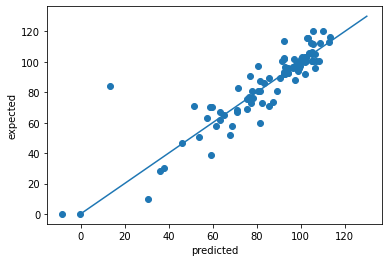

In [26]:
plt.scatter(y_pred_test,y_test)
plt.plot(np.linspace(0,130,10),np.linspace(0,130,10))
plt.xlabel('predicted')
plt.ylabel('expected')

In [78]:
data_error = pd.DataFrame(columns=['SMILES','MAE'])
data_error['SMILES'] = X_test.iloc[np.where(mae>20)[0]]['SMILES'].values
data_error['MAE'] = mae[np.where(mae>20)[0]]

In [80]:
data_error

,SMILES,MAE
0,C1CCCCCC1,20.694417
1,CCCCC(CC)CC,70.643821
2,CCCC#CCCC,22.080342
3,c1ccc2c(c1)C=CC2,21.287554
4,C1CCC(C1)C1CCCC1,20.835007


### Applicability domain

1. OneClassSVM

In [28]:
mean_inside = []

for nu in np.linspace(0.001,0.99,20):

    clf = OneClassSVM(nu=nu, kernel="rbf", gamma=0.1)
    clf.fit(X_train.values[:,1:])
    label = clf.predict(sc.transform(X_test)[X_train.columns[1:]])
    mean_inside.append(mae[np.where(label>0)[0]].mean())



Text(0, 0.5, 'MAE')

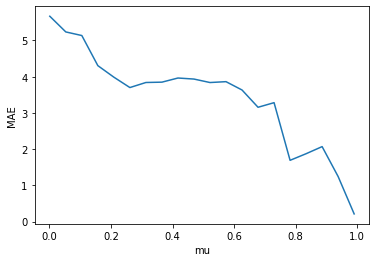

In [29]:
plt.plot(np.linspace(0.001,0.99,20),mean_inside)
plt.xlabel('mu')
plt.ylabel('MAE')

2.Tanimato distance

In [30]:
DM = mean_tanimato
Tanimato_dist = X_test['SMILES'].apply(lambda x: DM(x,X_train)).values

Text(0, 0.5, 'MAE')

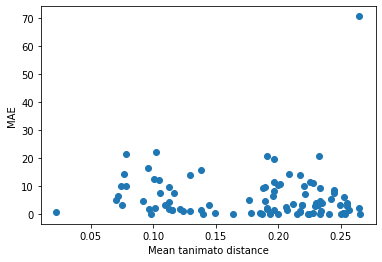

In [31]:
plt.scatter(Tanimato_dist,mae)
plt.xlabel('Mean tanimato distance')
plt.ylabel('MAE')

In [32]:
spread_tanimato = Tanimato_dist.max() - Tanimato_dist.min()

mean_inside2 = []
for i in range(1,20):
    upper_bound = Tanimato_dist.max() - i*spread_tanimato/20
    mean_inside2.append(mae[np.where(Tanimato_dist<upper_bound)[0]].mean())

Text(0, 0.5, 'MAE')

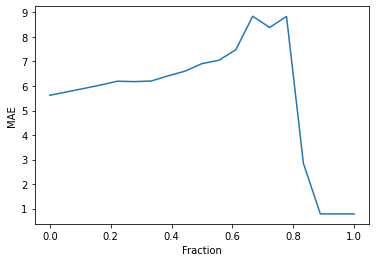

In [33]:
plt.plot(np.linspace(0,1,19),mean_inside2)
plt.xlabel('Fraction')
plt.ylabel('MAE')

In [84]:
def box_plot(dist,mae):

    df_  = pd.DataFrame(np.vstack((dist,mae)).T,columns=['dist','MAE'])
    bins = pd.cut(df_.iloc[:,0], list(np.linspace(dist.max(), dist.min(), 5))[::-1])

    fig,ax = plt.subplots()
    ax.boxplot([g[1] for g in df_.groupby(bins)['MAE']])
    ax.set_xticklabels(str(g[0])[1:-1] for g in df_.groupby(bins)['MAE'])
    ax.set_xlabel('distance bins')
    ax.set_ylabel('MAE')

    fig.tight_layout()


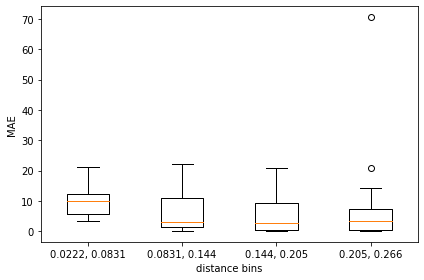

In [85]:
box_plot(Tanimato_dist,mae)

3. Leaverage distance

In [55]:
x_test_normed = sc.transform(X_test)[X_train.columns].values[:,1:]
lev_dist      = [Leverage(x_test_normed[i,:],X_train.values[:,1:]) for i in range(len(X_test))]

Text(0, 0.5, 'MAE')

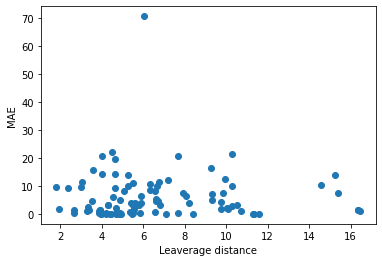

In [57]:
plt.scatter(lev_dist,mae)
plt.xlabel('Leaverage distance')
plt.ylabel('MAE')

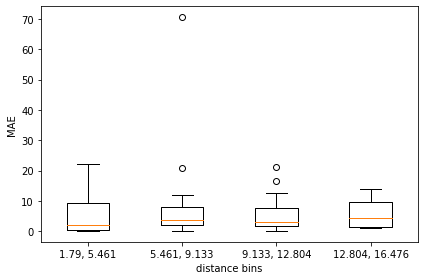

In [86]:
box_plot(np.array(lev_dist),mae)


4. Isolation forest

In [87]:
from sklearn.ensemble import IsolationForest

In [89]:
mean_inside = []

for cont in np.linspace(0.001,0.99,20):

    clf = IsolationForest(n_estimators=10, max_samples='auto', contamination=cont,
                          max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    clf.fit(X_train.values[:,1:])
    label = clf.predict(sc.transform(X_test)[X_train.columns[1:]])
    mean_inside.append(mae[np.where(label>0)[0]].mean())

Text(0, 0.5, 'MAE')

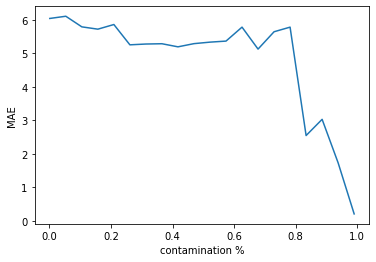

In [91]:
plt.plot(np.linspace(0.001,0.99,20),mean_inside)
plt.xlabel('contamination %')
plt.ylabel('MAE')